In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as preproc
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree,metrics
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import statsmodels.api as sm

In [2]:
data=pd.read_csv('AllFeatures.csv')
df = pd.read_excel('DATACASE1.xlsx')
y=np.array(df.LoadFactor)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Backward Elimination
cols = list(data.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = data[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['FlightNumber', 'SeatCapacity', 'Month', 'Hour', 'Dayofweek', 'Dayofyear', 'Quarter', 'QuarterStart', 'QuarterEnd', 'MonthStart', 'YearStart', 'YearEnd', 'AirlineAY', 'AirlineBJ', 'AirlineBT', 'AirlineCD', 'AirlineCL', 'AirlineCN', 'AirlineDO', 'AirlineDU', 'AirlineE4', 'AirlineEM', 'AirlineEN', 'AirlineFB', 'AirlineFK', 'AirlineFO', 'AirlineFP', 'AirlineFZ', 'AirlineGQ', 'AirlineIA', 'AirlineIK', 'AirlineIR', 'AirlineJE', 'AirlineJN', 'AirlineJNL', 'AirlineJZ', 'AirlineKJ', 'AirlineKL', 'AirlineKM', 'AirlineKN', 'AirlineKO', 'AirlineKU', 'AirlineLJ', 'AirlineLW', 'AirlineLZ', 'AirlineMC', 'AirlineMD', 'AirlineML', 'AirlineNH', 'AirlineNI', 'AirlineNU', 'AirlineNV', 'AirlineNW', 'AirlinePJ', 'AirlinePL', 'AirlinePO', 'AirlinePU', 'AirlinePW', 'AirlineSH', 'AirlineSQ', 'AirlineSV', 'AirlineUI', 'AirlineUK', 'AirlineUU', 'AirlineV7', 'AirlineVJ', 'AirlineVW', 'AirlineW9', 'AirlineWU', 'AirlineXG', 'AirlineYQ', 'AirlineYU', 'AirlineZB', 'AirlineZD', 'AirlineZL', 'AirlineZP', 'AirlineZT',

In [7]:
X_selected=np.array(data[selected_features_BE].copy())

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.30, random_state=42)

In [86]:
y_test_idx=[list(y).index(el) for el in y_test]

In [87]:
model = neighbors.KNeighborsRegressor(n_neighbors = 5)
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [88]:
y_pred=model.predict(X_test)

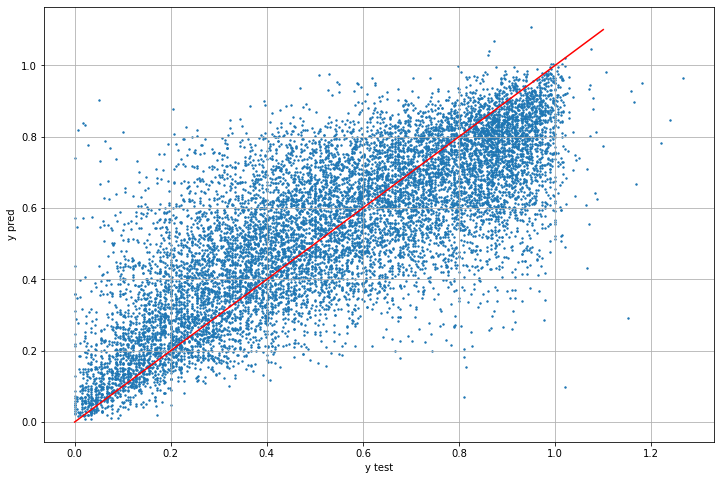

In [89]:
plt.figure(figsize=(12,8))
# plt.scatter(np.sort(y_test),np.sort(ypred),s=1)
plt.scatter(y_test,y_pred,s=2)
plt.xlabel('y test');plt.ylabel('y pred')
plt.plot(np.linspace(0,1.1),np.linspace(0,1.1),'r')
#plt.plot(np.linspace(0,max(y_test)),np.linspace(0,max(y_test)),'r')
plt.grid()
plt.show()

In [90]:
np.mean(np.abs((y_test-y_pred)))

0.13415461566262207

In [91]:
np.mean((y_test-y_pred)**2)

0.03085734309049202

In [92]:
def estimated_total_accuracy(y,y_esti,SC_non_norm):
    #Deviation per flight = (Actual passengers – Forecasted passengers) / Actual passengers per flight
    #Accuracy per flight = 100% - | Deviation per flight |
    
    Actual_pass=np.array(y).T*SC_non_norm
    Forecast_pass=y_esti.T*SC_non_norm
    
    ind0=np.where(Actual_pass==0)[0]
    
    Actual_pass= np.delete(Actual_pass,ind0)
    Forecast_pass= np.delete(Forecast_pass,ind0)

    Dev= (np.abs(Actual_pass-Forecast_pass))/Actual_pass

    Exp_acc= 1-Dev
    T_exp_acc=np.mean(Exp_acc)*100

    return T_exp_acc


def compute_mse(X,beta,y):
    yhat = np.matmul(X, beta)
    res = (y - yhat) ** 2    
    mse = np.mean(res)
    
    return mse, res, yhat

In [93]:
SC_non_norm=np.array(df.SeatCapacity[y_test_idx])

In [94]:
T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
print('Total Expected Accuracy:',T_ex_acc)

Total Expected Accuracy: 52.0242037988603


### Tune number of neighbors

In [95]:
n_neighbors=list(range(1,10,1))

# Better way of doing k fold cross validation
K=5
kf = KFold(n_splits=K)
Error0=np.zeros([K,len(n_neighbors)])

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train = X_selected[train_index]
    y_train = y[train_index]
    X_test = X_selected[test_index]
    y_test = y[test_index]
    y_test_idx=[list(y).index(el) for el in y_test]

    for j,c in enumerate(n_neighbors):
        # train
        model = neighbors.KNeighborsRegressor(n_neighbors = c,n_jobs=-1)
        model.fit(X_train,y_train)
        # predict
        y_pred=model.predict(X_test)
        # compute accuracy
        SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
        T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
        Error0[i,j]=T_ex_acc
    print(int((i+1)/K*20),'folds completed')

4 folds completed
8 folds completed
12 folds completed
16 folds completed
20 folds completed


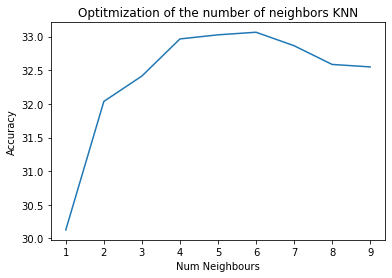

In [96]:
plt.plot(list(range(1,10,1)),np.mean(Error0,axis=0))
plt.xlabel('Num Neighbours');plt.ylabel('Accuracy')
plt.title('Optitmization of the number of neighbors KNN (weights=uniform)');plt.show()
plt.savefig('num_KNN_uniform.png')

### Tune number of neighbors (with weight = distance)

In [99]:
n_neighbors=list(range(1,10,1))

# Better way of doing k fold cross validation
K=5
kf = KFold(n_splits=K)
Error00=np.zeros([K,len(n_neighbors)])

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train = X_selected[train_index]
    y_train = y[train_index]
    X_test = X_selected[test_index]
    y_test = y[test_index]
    y_test_idx=[list(y).index(el) for el in y_test]

    for j,c in enumerate(n_neighbors):
        # train
        model = neighbors.KNeighborsRegressor(n_neighbors = c,weights='distance',n_jobs=-1)
        model.fit(X_train,y_train)
        # predict
        y_pred=model.predict(X_test)
        # compute accuracy
        SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
        T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
        Error00[i,j]=T_ex_acc
    print(int((i+1)/K*5),'folds completed')

1 folds completed
2 folds completed
3 folds completed
4 folds completed
5 folds completed


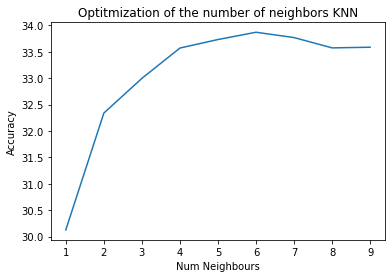

In [100]:
plt.plot(list(range(1,10,1)),np.mean(Error00,axis=0))
plt.xlabel('Num Neighbours');plt.ylabel('Accuracy')
plt.title('Optitmization of the number of neighbors KNN')
plt.savefig('num_KNN_distance.png');plt.show()

In [103]:
# Define optimal number of knn
knn_opt=6
weight_opt='distance'

### Tune p

In [108]:
p=[1,2]

# Better way of doing k fold cross validation
K=5
kf = KFold(n_splits=K)
Error2=np.zeros([K,len(p)])

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train = X_selected[train_index]
    y_train = y[train_index]
    X_test = X_selected[test_index]
    y_test = y[test_index]
    y_test_idx=[list(y).index(el) for el in y_test]

    for j,c in enumerate(p):
        # train
        model = neighbors.KNeighborsRegressor(n_neighbors = knn_opt,weights=weight_opt,p=c,n_jobs=-1)
        model.fit(X_train,y_train)
        # predict
        y_pred=model.predict(X_test)
        # compute accuracy
        SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
        T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
        Error2[i,j]=T_ex_acc
    print(int((i+1)/K*5),'folds completed')

1 folds completed
2 folds completed
3 folds completed
4 folds completed
5 folds completed


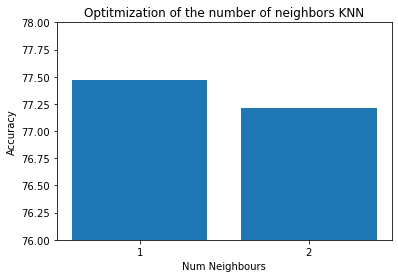

In [107]:
plt.bar(['1','2'],np.mean(Error2,axis=0))
plt.ylim([76,78])
plt.xlabel('Num Neighbours');plt.ylabel('Accuracy')
plt.title('Optitmization of the number of neighbors KNN')
plt.savefig('num_KNN_distance.png');plt.show()

The highest accuracy obtained is by setting knn=1. Thus, it does not make sense to optimize the other parameters, as no changes will be observed.

### Train the model again once optimized

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.30, random_state=42)
y_test_idx=[list(y).index(el) for el in y_test]

In [41]:
model = neighbors.KNeighborsRegressor(n_neighbors = knn_opt,n_jobs=-1)
model.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                    weights='uniform')

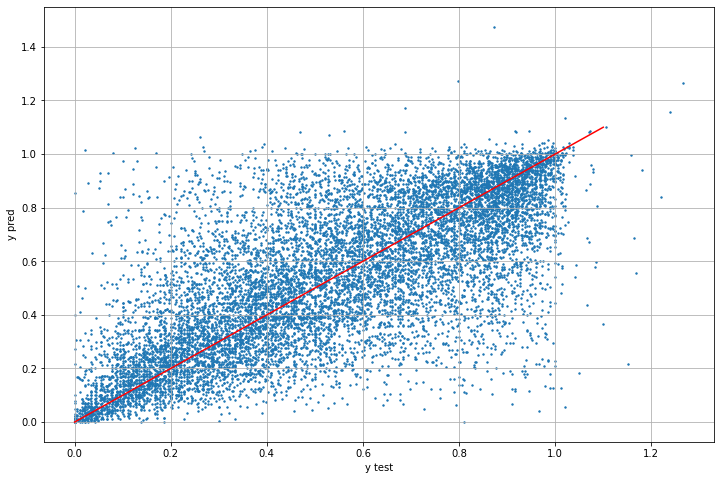

In [43]:
y_pred=model.predict(X_test)
plt.figure(figsize=(12,8))
# plt.scatter(np.sort(y_test),np.sort(ypred),s=1)
plt.scatter(y_test,y_pred,s=2)
plt.xlabel('y test');plt.ylabel('y pred')
plt.plot(np.linspace(0,1.1),np.linspace(0,1.1),'r')
#plt.plot(np.linspace(0,max(y_test)),np.linspace(0,max(y_test)),'r')
plt.grid()
plt.show()

In [44]:
SC_non_norm=np.array(data.SeatCapacity[y_test_idx])
T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
print('Total Expected Accuracy:',T_ex_acc)

Total Expected Accuracy: 88.63421121660302


#### Compute Accuracy using CV

In [45]:
K=10
kf = KFold(n_splits=K)
Accuracy=np.zeros(K)

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train = X_selected[train_index]
    y_train = y[train_index]
    X_test = X_selected[test_index]
    y_test = y[test_index]
    y_test_idx=[list(y).index(el) for el in y_test]
    # train model
    model = neighbors.KNeighborsRegressor(n_neighbors = knn_opt,n_jobs=-1)
    model.fit(X_train,y_train)
    # predict model
    y_pred=model.predict(X_test)
    SC_non_norm=np.array(data.SeatCapacity[y_test_idx])
    T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
    Accuracy[i]=T_ex_acc;print('Total Expected Accuracy:',T_ex_acc)

Total Expected Accuracy: 53.37896015078174
Total Expected Accuracy: 93.73816240860494
Total Expected Accuracy: 86.17702838654819
Total Expected Accuracy: 97.6248401412372
Total Expected Accuracy: 93.0228587489586
Total Expected Accuracy: 89.24012210591941
Total Expected Accuracy: 70.90133233433681
Total Expected Accuracy: 83.72078013168833
Total Expected Accuracy: 78.94597836704271
Total Expected Accuracy: 88.0217755857887


In [46]:
np.mean(Accuracy)

83.47718383609065

### Training with the best training fold

In [59]:
train_index,test_index=list(kf.split(X_selected))[3]
X_train = X_selected[train_index]
y_train = y[train_index]
X_test = X_selected[test_index]
y_test = y[test_index]
y_test_idx=[list(y).index(el) for el in y_test]

In [73]:
model = neighbors.KNeighborsRegressor(n_neighbors = knn_opt,n_jobs=-1)
model.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                    weights='uniform')

In [74]:
y_pred=model.predict(X_test)

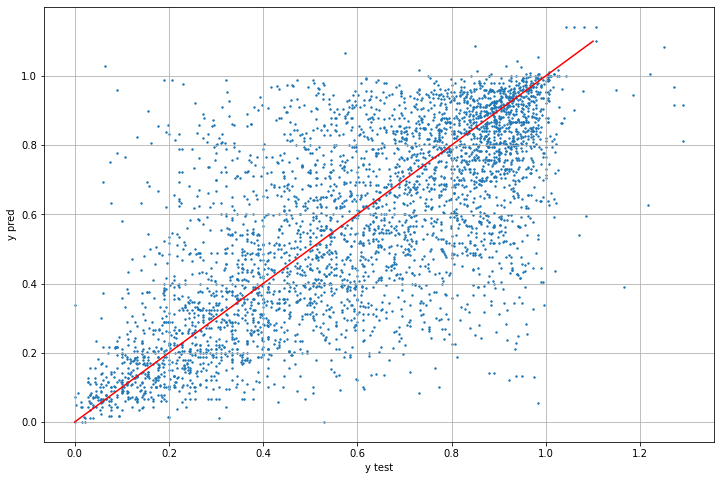

In [75]:
plt.figure(figsize=(12,8))
# plt.scatter(np.sort(y_test),np.sort(ypred),s=1)
plt.scatter(y_test,y_pred,s=2)
plt.xlabel('y test');plt.ylabel('y pred')
plt.plot(np.linspace(0,1.1),np.linspace(0,1.1),'r')
#plt.plot(np.linspace(0,max(y_test)),np.linspace(0,max(y_test)),'r')
plt.grid()
plt.show()

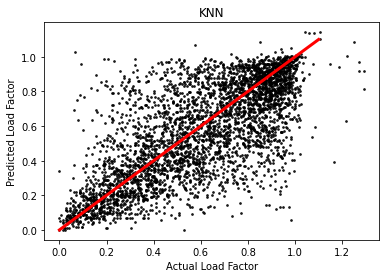

In [81]:
plt.scatter(y_test,y_pred,s=3,alpha=0.8,c ="black")
plt.plot(np.linspace(0,1.1),np.linspace(0,1.1),'r',linewidth=3)
plt.ylabel('Predicted Load Factor');plt.xlabel('Actual Load Factor');plt.title('KNN')
plt.savefig('KNN.png');plt.show()

In [72]:
SC_non_norm=np.array(data.SeatCapacity[y_test_idx])
T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
print('Total Expected Accuracy:',T_ex_acc)

Total Expected Accuracy: 97.6248401412372


### Plot for every fold

Total Expected Accuracy: 53.37896015078174


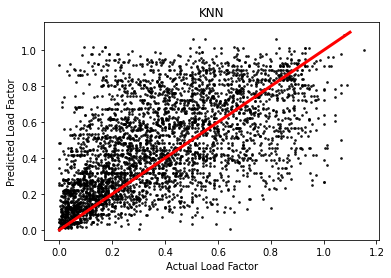

Total Expected Accuracy: 93.73816240860494


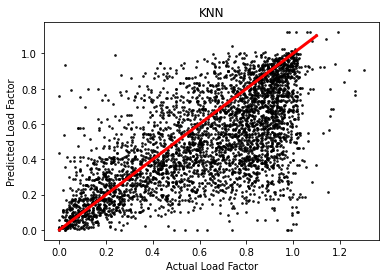

Total Expected Accuracy: 86.17702838654819


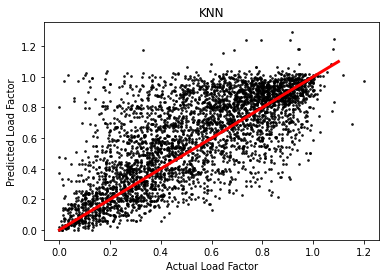

Total Expected Accuracy: 97.6248401412372


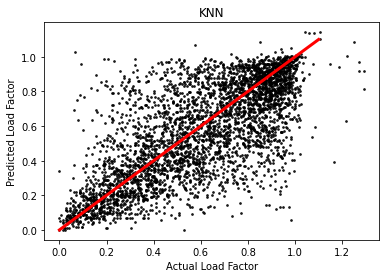

Total Expected Accuracy: 93.0228587489586


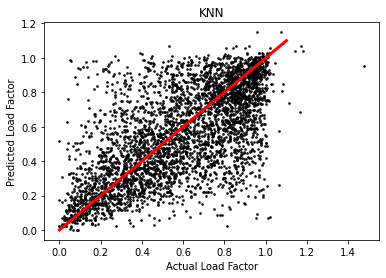

Total Expected Accuracy: 89.24012210591941


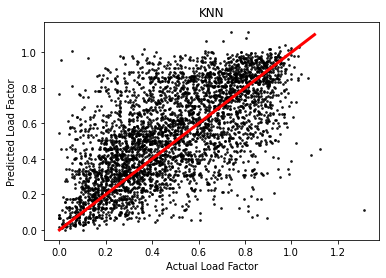

Total Expected Accuracy: 70.90133233433681


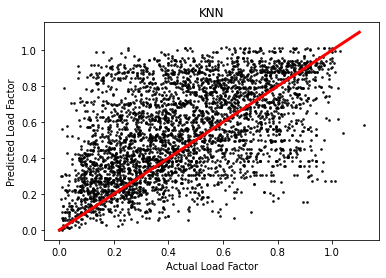

Total Expected Accuracy: 83.72078013168833


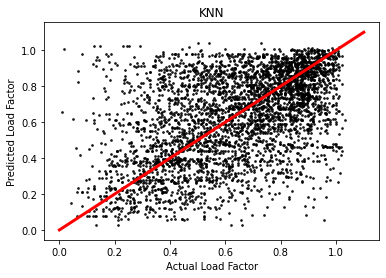

Total Expected Accuracy: 78.94597836704271


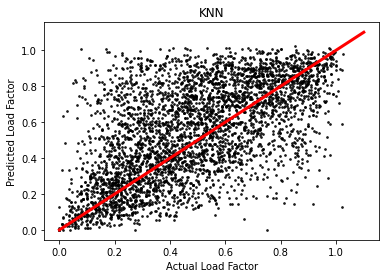

Total Expected Accuracy: 88.0217755857887


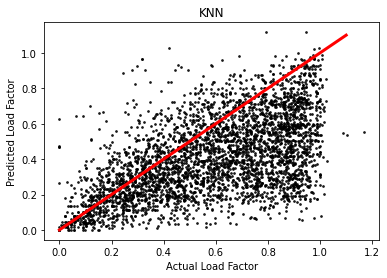

In [82]:
K=10
kf = KFold(n_splits=K)
Accuracy=np.zeros(K)

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train = X_selected[train_index]
    y_train = y[train_index]
    X_test = X_selected[test_index]
    y_test = y[test_index]
    y_test_idx=[list(y).index(el) for el in y_test]
    # train model
    model = neighbors.KNeighborsRegressor(n_neighbors = knn_opt,n_jobs=-1)
    model.fit(X_train,y_train)
    # predict model
    y_pred=model.predict(X_test)
    SC_non_norm=np.array(data.SeatCapacity[y_test_idx])
    T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
    Accuracy[i]=T_ex_acc;print('Total Expected Accuracy:',T_ex_acc)
    plt.scatter(y_test,y_pred,s=3,alpha=0.8,c ="black")
    plt.plot(np.linspace(0,1.1),np.linspace(0,1.1),'r',linewidth=3)
    plt.ylabel('Predicted Load Factor');plt.xlabel('Actual Load Factor');plt.title('KNN')
    plt.show()

## Double CV Optimitzation

#### Before optimization

In [165]:
X_out_train, X_out_test, y_out_train, y_out_test = train_test_split(X_selected, y, test_size=0.30, random_state=42)

In [172]:
y_test_out_idx=[list(y).index(el) for el in y_out_test]

In [169]:
model = neighbors.KNeighborsRegressor()
model.fit(X_out_train, y_out_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

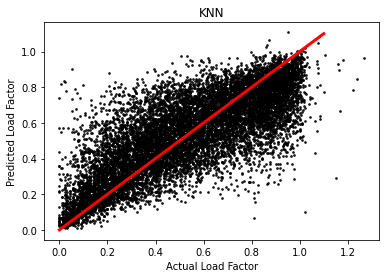

In [171]:
y_pred=model.predict(X_out_test)
plt.scatter(y_out_test,y_pred,s=3,alpha=0.8,c ="black")
plt.plot(np.linspace(0,1.1),np.linspace(0,1.1),'r',linewidth=3)
plt.ylabel('Predicted Load Factor');plt.xlabel('Actual Load Factor');plt.title('KNN')
plt.savefig('KNN_before.png');plt.show()

In [174]:
SC_non_norm=np.array(df.SeatCapacity[y_test_out_idx])
T_ex_acc=estimated_total_accuracy(y_out_test,y_pred,SC_non_norm)
print('Total Expected Accuracy:',T_ex_acc)

Total Expected Accuracy: 52.0242037988603


#### After optimization

In [150]:
# weight equal uniform
n_neighbors=list(range(1,10,1))

# Better way of doing k fold cross validation
K=5
kf = KFold(n_splits=K)
Error00=np.zeros([K,len(n_neighbors)])

for i, (train_index, test_index) in enumerate(kf.split(X_out_train)):
    X_train = X_out_train[train_index]
    y_train = y_out_train[train_index]
    X_test = X_out_train[test_index]
    y_test = y_out_train[test_index]
    y_test_idx=[list(y_out_train).index(el) for el in y_test]

    for j,c in enumerate(n_neighbors):
        # train
        model = neighbors.KNeighborsRegressor(n_neighbors = c,weights='uniform',n_jobs=-1)
        model.fit(X_train,y_train)
        # predict
        y_pred=model.predict(X_test)
        # compute accuracy
        SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
        T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
        Error00[i,j]=T_ex_acc
    print(int((i+1)/K*5),'folds completed')

1 folds completed
2 folds completed
3 folds completed
4 folds completed
5 folds completed


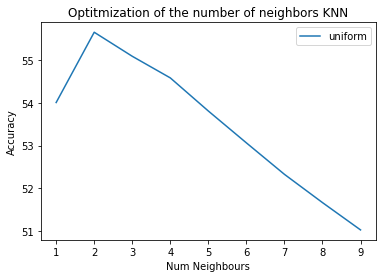

In [185]:
plt.plot(list(range(1,10,1)),np.mean(Error00,axis=0),label='uniform')
plt.xlabel('Num Neighbours');plt.ylabel('Accuracy')
plt.title('Optitmization of the number of neighbors KNN')
plt.legend()
plt.savefig('num_KNN_uniform.png');plt.show()

In [186]:
# weight equal distance
n_neighbors=list(range(1,10,1))

# Better way of doing k fold cross validation
K=5
kf = KFold(n_splits=K)
Error0=np.zeros([K,len(n_neighbors)])

for i, (train_index, test_index) in enumerate(kf.split(X_out_train)):
    X_train = X_out_train[train_index]
    y_train = y_out_train[train_index]
    X_test = X_out_train[test_index]
    y_test = y_out_train[test_index]
    y_test_idx=[list(y_out_train).index(el) for el in y_test]

    for j,c in enumerate(n_neighbors):
        # train
        model = neighbors.KNeighborsRegressor(n_neighbors = c,weights='distance',n_jobs=-1)
        model.fit(X_train,y_train)
        # predict
        y_pred=model.predict(X_test)
        # compute accuracy
        SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
        T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
        Error0[i,j]=T_ex_acc
    print(int((i+1)/K*5),'folds completed')

1 folds completed
2 folds completed
3 folds completed
4 folds completed
5 folds completed


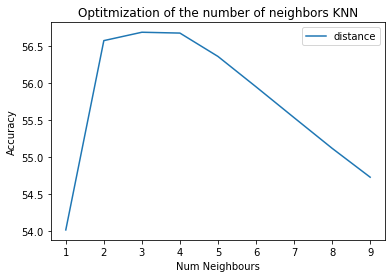

In [188]:
plt.plot(list(range(1,10,1)),np.mean(Error0,axis=0),label='distance')
plt.xlabel('Num Neighbours');plt.ylabel('Accuracy')
plt.title('Optitmization of the number of neighbors KNN')
plt.legend()
plt.savefig('num_KNN_distance.png');plt.show()

In [114]:
knn_opt=np.round(n_neighbors[list(np.mean(Error00,axis=0)).index(max(np.mean(Error00,axis=0)))],2)
knn_opt

3

In [127]:
algorithm=['auto','ball_tree','kd_tree','brute']

# Better way of doing k fold cross validation
K=5
kf = KFold(n_splits=K)
Error1=np.zeros([K,len(algorithm),2])

for i, (train_index, test_index) in enumerate(kf.split(X_out_train)):
    X_train = X_out_train[train_index]
    y_train = y_out_train[train_index]
    X_test = X_out_train[test_index]
    y_test = y_out_train[test_index]
    y_test_idx=[list(y_out_train).index(el) for el in y_test]

    for j,c in enumerate(algorithm):
        for k,d in enumerate(p):
            # train
            model = neighbors.KNeighborsRegressor(n_neighbors = knn_opt,weights='distance',
                                                  algorithm=c,p=d,n_jobs=-1)
            model.fit(X_train,y_train)
            # predict
            y_pred=model.predict(X_test)
            # compute accuracy
            SC_non_norm=np.array(df.SeatCapacity[y_test_idx])
            T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm)
            Error1[i,j,k]=T_ex_acc
    print(int((i+1)/K*5),'folds completed')

1 folds completed
2 folds completed
3 folds completed
4 folds completed
5 folds completed


In [135]:
data_plot=np.mean(Error1,axis=0)
data_plot[:,0]

array([58.41891663, 58.41906133, 58.41891663, 58.41485369])

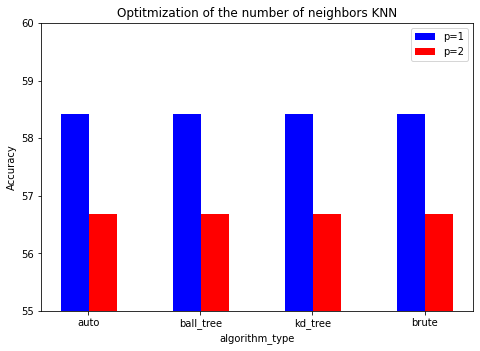

In [193]:
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data_plot[:,0], color = 'b', width = 0.25,label='p=1')
ax.bar(X + 0.25, data_plot[:,1], color = 'r', width = 0.25,label='p=2')
plt.xlabel('algorithm_type');plt.ylabel('Accuracy')
plt.title('Optitmization of the number of neighbors KNN')
plt.ylim([55,60]);plt.legend()
plt.xticks(X+0.12, ['auto','ball_tree','kd_tree','brute'])
plt.savefig('p_value_and_algorithm.png')
plt.show()

In [156]:
p_opt=1
algorithm_opt=algorithm[list(data_plot[:,0]).index(max(data_plot[:,0]))]

#### After optimization

In [190]:
X_out_train, X_out_test, y_out_train, y_out_test = train_test_split(X_selected, y, test_size=0.30, random_state=42)
y_test_out_idx=[list(y).index(el) for el in y_out_test]

# Optimized model
model = neighbors.KNeighborsRegressor(n_neighbors = knn_opt,weights='distance',
                                      algorithm=algorithm_opt,p=p_opt,n_jobs=-1)
model.fit(X_out_train, y_out_train)
y_pred=model.predict(X_out_test)

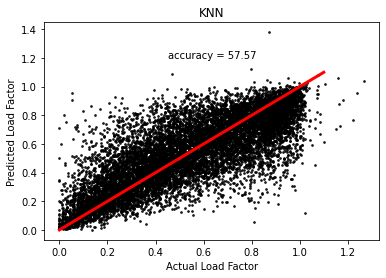

In [198]:
plt.scatter(y_out_test,y_pred,s=3,alpha=0.8,c ="black")
plt.plot(np.linspace(0,1.1),np.linspace(0,1.1),'r',linewidth=3)
plt.ylabel('Predicted Load Factor');plt.xlabel('Actual Load Factor');plt.title('KNN')
plt.savefig('KNN_after.png');plt.text(0.45,1.2,'accuracy = 57.57');plt.show()

In [176]:
SC_non_norm=np.array(df.SeatCapacity[y_test_out_idx])
T_ex_acc=estimated_total_accuracy(y_out_test,y_pred,SC_non_norm)
print('Total Expected Accuracy:',T_ex_acc)

Total Expected Accuracy: 57.565038182799896
